In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import pyOpenLPT as lpt
redirector = lpt.PythonStreamRedirector()

### Load camera parameters and images

In [2]:
ncam = 2
bit_depth = 8

# load cam 
cam = []
intensity_max = []
useid_list = []
for i in range(ncam):
    file = '../../test/inputs/test_BubbleRefImg/cam' + str(i+1) + '.txt'
    cam.append(lpt.math.Camera(file))
    intensity_max.append(2**bit_depth-1)
    useid_list.append(i)
cam_list = lpt.math.CamList(cam, intensity_max, useid_list)
# print(cam_list.to_dict())

# load image path
imgio_list = []
folder = '../../test/inputs/test_BubbleRefImg/'
for i in range(ncam):
    file = 'cam' + str(i+1) + 'ImageNames.txt'
    imgio_list.append(lpt.math.ImageIO(folder, file))
    
# load bubble image
img_list = []
img_np_list = []
for i in range(ncam):
    img = imgio_list[i].loadImg(0)
    # invert image
    # for i in range(img.getDimRow() * img.getDimCol()):
    #     img[i] = (2**16-1) - img[i]
    img_np = lpt.math.matrix_to_numpy(img)
    img_list.append(img)
    img_np_list.append(img_np)


### Find 2D bubbles in each camera

cam 1 found 43 bubbles
cam 2 found 48 bubbles


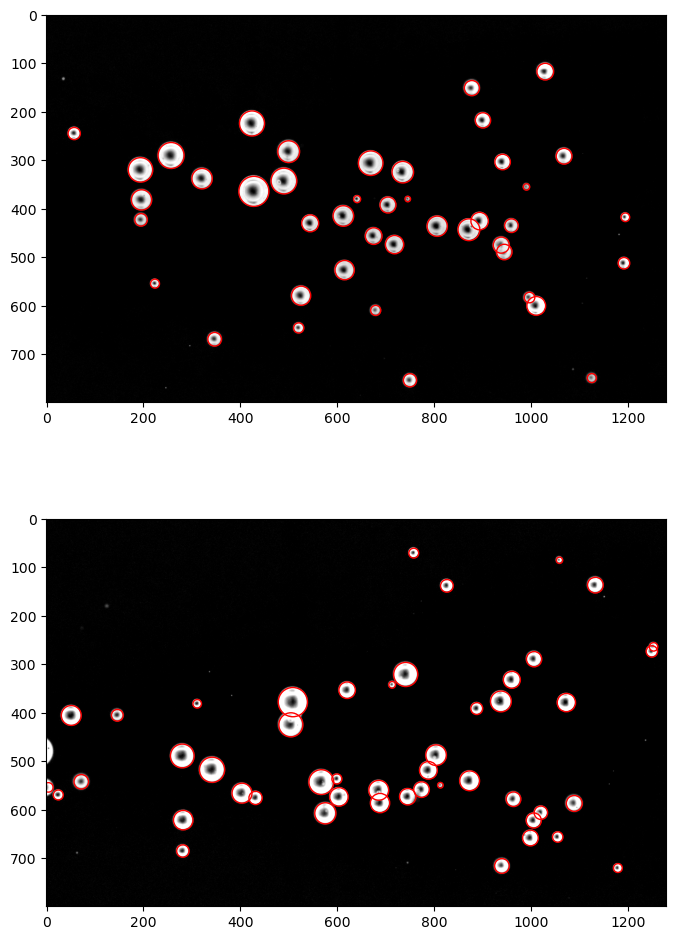

In [3]:
# define bubble property: [rmin,rmax,sensitivity]
bubble_property = [5, 50, 0.85]
bb2d_list_all = []
for i in range(ncam):
    bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_list[i], bubble_property)
    bb2d_list_all.append(bb2d_list)
    print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)
    
fig, axs = plt.subplots(ncam, 1, figsize=(8, 12))
for i in range(ncam):
    axs[i].imshow(img_np_list[i], cmap='gray')
    for bb2d in bb2d_list_all[i]:
        draw_circle(axs[i], bb2d._pt_center, bb2d._r_px, color='red')

### Bubble resize

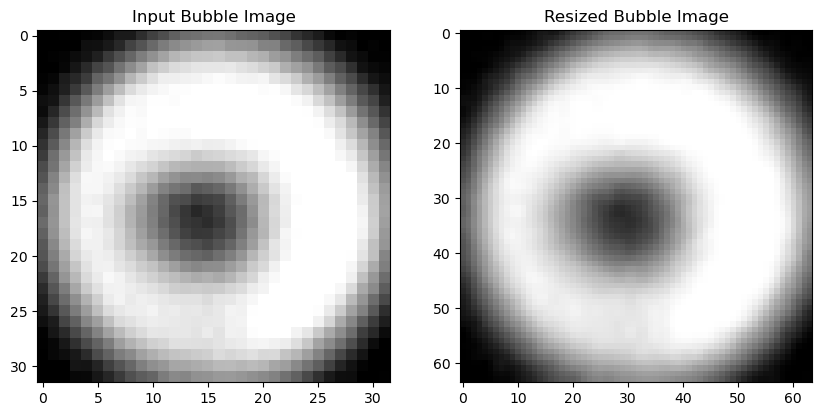

In [4]:
# test bubble resize 
cam_id = 0
bb2d = bb2d_list_all[cam_id][0]  # use the first bubble for resizing
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
img_input_np = img_np_list[cam_id][row_min:row_max, col_min:col_max].copy() 
img_input = lpt.math.Image(lpt.math.numpy_to_matrix(img_input_np))

bb_resize = lpt.object.BubbleResize()
img_output = bb_resize.ResizeBubble(img_input, 64, 2**bit_depth-1)
img_output_np = lpt.math.matrix_to_numpy(img_output)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_input_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title('Input Bubble Image')
plt.subplot(1, 2, 2)
plt.imshow(img_output_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title('Resized Bubble Image')
plt.show()

### Stereomatch for bubbles

In [5]:
# stereo match
sm_param = lpt.stb.SMParam()
sm_param.tor_2d = 3.
# sm_param.tor_3d = 2.8e-2
sm_param.tor_3d = 5.0e-2
sm_param.n_thread = 6
sm_param.check_id = 2
sm_param.check_radius = 3
sm_param.is_delete_ghost = True
sm_param.is_update_inner_var = True

sm = lpt.stb.StereoMatch(sm_param, cam_list)
bb3d_list = sm.match(bb2d_list_all)
# sm.saveObjInfo(folder+'bb3d_list.csv', bb3d_list)
print('Number of 3D bubbles:', len(bb3d_list))


	Finish deleting gohst match: n_del = 4, n_after_del = 35.


Number of 3D bubbles: 35


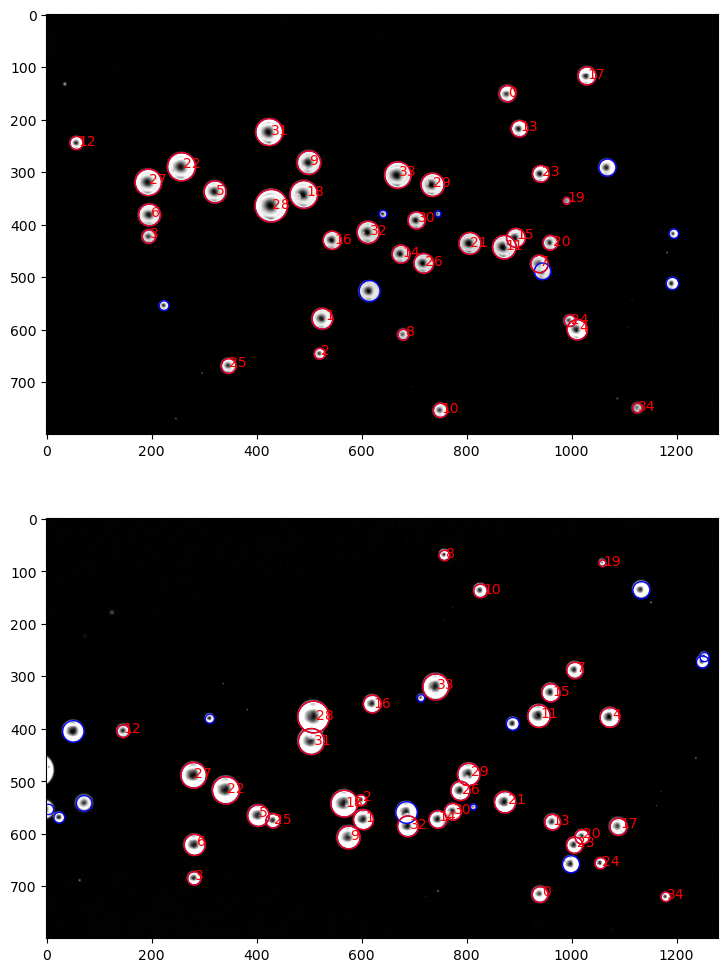

In [6]:
# plot 2d projection on each camera
fig, axs = plt.subplots(ncam, 1, figsize=(10, 12))
for cam_id in range(ncam):
    axs[cam_id].imshow(img_np_list[cam_id], cmap='gray')
    
    for bb2d in bb2d_list_all[cam_id]:
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='blue')
    
    for i in range(len(bb3d_list)):
        bb3d = bb3d_list[i]
        bb2d = bb3d._bb2d_list[cam_id]
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='red')
        axs[cam_id].text(bb2d._pt_center[0] + 5 * np.random.random(), bb2d._pt_center[1] + 5 * np.random.random(), str(i), color='red', alpha=1.0)


### Get bubble reference image

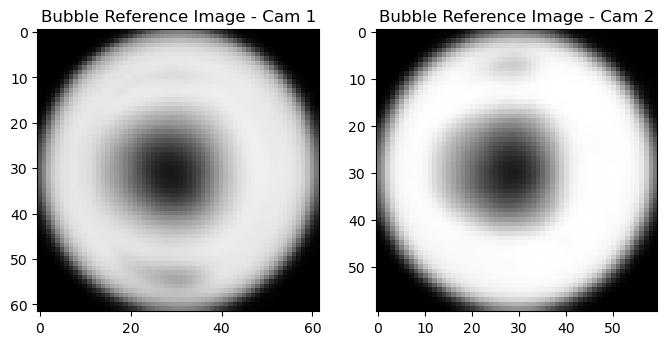

In [7]:
import tifffile
# import os
# os.mkdir('../../test/results/test_BubbleRefImg', exist_ok=True)

# get bubble reference image
bb_refimg = lpt.object.BubbleRefImg(cam_list)
is_valid = bb_refimg.GetBubbleRefImg(bb3d_list, bb2d_list_all, img_list)

fig, axs = plt.subplots(1, ncam, figsize=(8, 6))
for cam_id in range(ncam):
    img_out_np = lpt.math.matrix_to_numpy(bb_refimg[cam_id])
    # filename = f'../../test/results/test_BubbleRefImg/bubble_refimg_cam{cam_id + 1}.tiff'
    # tifffile.imwrite(filename, img_out_np.astype(np.uint16))
    axs[cam_id].imshow(img_out_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    # axs[cam_id].imshow(img_out_np, cmap='gray')
    axs[cam_id].set_title(f'Bubble Reference Image - Cam {cam_id + 1}')

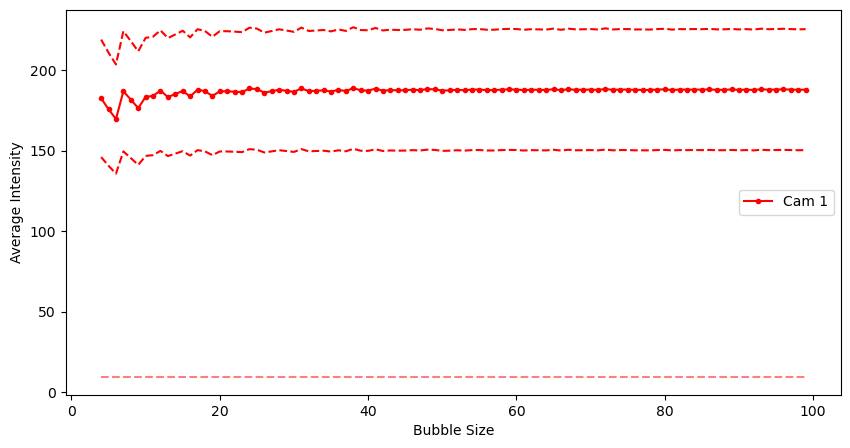

In [8]:
# test if the average intensity will change when it is resized 
size_range = np.arange(4, 100)
avg_intensity = np.zeros((len(size_range),2))

# resize ref image 
for i in range(len(size_range)):
# for i in [0]:
    img_size = size_range[i]
    bb_resize = lpt.object.BubbleResize()
    for cam_id in range(ncam):
        img_ref = bb_resize.ResizeBubble(bb_refimg[cam_id], img_size, 2**bit_depth-1)
        img_ref_np = lpt.math.matrix_to_numpy(img_ref)
        # avg_intensity[i, cam_id] = np.mean(img_ref_np)
        n_sum = 0
        for row_id in range(img_size):
            for col_id in range(img_size):
                dist = np.sqrt((row_id - (img_size-1)/2)**2 + (col_id - (img_size-1)/2)**2)
                if dist < img_size/2.:
                    avg_intensity[i, cam_id] += img_ref_np[row_id, col_id]
                    n_sum += 1
        if n_sum > 0:
            avg_intensity[i, cam_id] /= n_sum
            
        # plt.figure(figsize=(10, 5))
        # plt.imshow(img_ref_np, cmap='gray')
        
plt.figure(figsize=(10, 5))
color_list = ['r', 'b']
# for cam_id in range(ncam):
for cam_id in [0]:
    plt.plot(size_range, avg_intensity[:, cam_id], color_list[cam_id] + '.-', label='Cam 1')
    plt.plot(size_range, avg_intensity[:, cam_id]*0.8, color_list[cam_id] + '--', label=None)
    plt.plot(size_range, avg_intensity[:, cam_id]*1.2, color_list[cam_id] + '--', label=None)
    plt.plot(size_range, np.mean(img_np_list[cam_id])*np.ones(len(size_range)), color_list[cam_id] + '--', alpha=0.5, label=None)
plt.xlabel('Bubble Size')   
plt.ylabel('Average Intensity')
plt.legend()
plt.show()

avg_intensity: 137.85318559556788
Image cross correlation: 0.8483734176183488


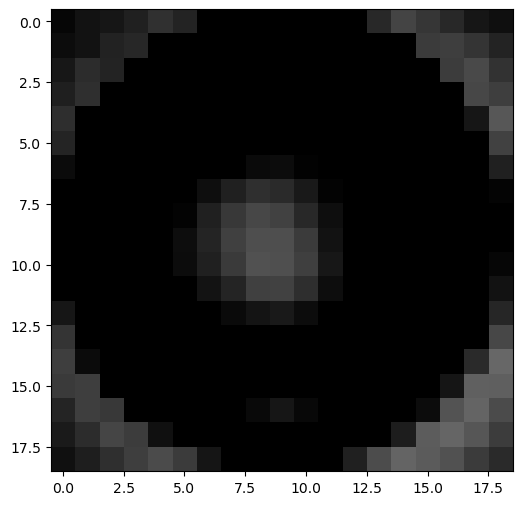

In [9]:
cam_id = 0
bb_id = 34 

# get bubble subimage
bb3d = bb3d_list[bb_id]
bb2d = bb3d._bb2d_list[cam_id]
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
# row_min = 600
# row_max = 700
# col_min = 0
# col_max = 100
img_size = min(row_max - row_min, col_max - col_min)
img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))
print('avg_intensity:', np.mean(img_np))

# resize ref image 
bb_resize = lpt.object.BubbleResize()
img_ref = bb_resize.ResizeBubble(bb_refimg[cam_id], img_np.shape[0], 2**bit_depth-1)
img_ref_np = lpt.math.matrix_to_numpy(img_ref)

# residue img
img_res_np = img_np - img_ref_np
img_res_np[img_res_np < 0] = 0  # set negative values to 0

plt.figure(figsize=(8, 6))
# plt.imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
# plt.imshow(img_ref_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.imshow(img_res_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)

# calculate image cross correlation
corr = lpt.math.imgCrossCorr(img, img_ref)
print(f'Image cross correlation: {corr}')

cam 96 found 42 bubbles
Cross-correlation: 0.8483734176183485


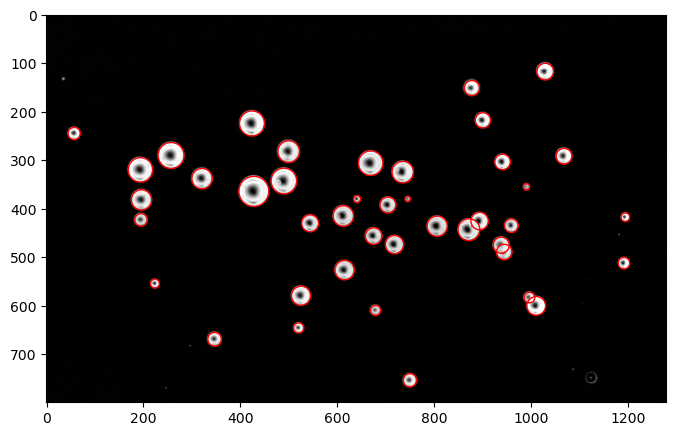

In [10]:
# test if bubble reference image is fine
img_full_np = img_np_list[cam_id].copy()
img_full_np[row_min:row_min+img_size, col_min:col_min+img_size] = img_res_np
img_full = lpt.math.Image(lpt.math.numpy_to_matrix(img_full_np))

bubble_property = [5, 50, 0.85]
bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_full, bubble_property)
print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)

fig = plt.figure(figsize=(8, 6))
plt.imshow(img_full_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
for bb2d in bb2d_list:
    draw_circle(plt.gca(), bb2d._pt_center, bb2d._r_px, color='red')
    
# Calculate cross-correlation between the original and reference images
img_np_mean = np.mean(img_np)
img_np_std = np.std(img_np)
img_ref_np_mean = np.mean(img_ref_np)
img_ref_np_std = np.std(img_ref_np)
cross_correlation = np.sum((img_np - img_np_mean) * (img_ref_np - img_ref_np_mean)) / (img_np.size * img_np_std * img_ref_np_std)
print(f'Cross-correlation: {cross_correlation}')

### Bubble radius projection & triangulation

Bubble 4 from cam 0: 0.43748509790732104
Bubble 4 from cam 1: 0.4417032264546463
Bubble 4 projected 2d radius on cam 0: 19.463305918474834
Bubble 4 found 2d radius on cam 0: 19.36992577158187
Bubble 4 projected 2d radius on cam 1: 18.809183991491167
Bubble 4 found 2d radius on cam 1: 18.89942582571635


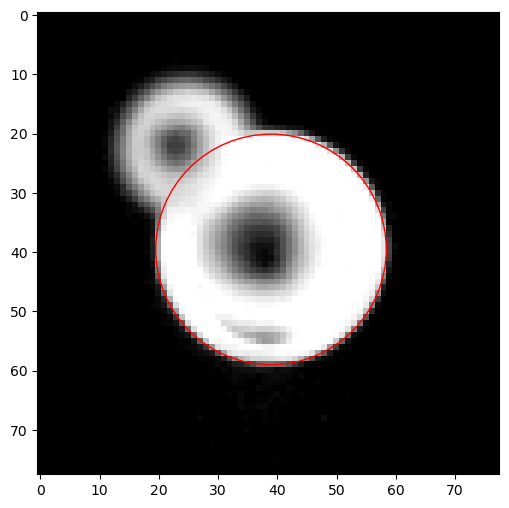

In [11]:
bb_id = 4 

# get 3d radius
r3d_list = []
for cam_id in range(ncam):
    # get 3d position in cam corrdinate
    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    r2 = bb3d_list[bb_id]._bb2d_list[cam_id]._r_px ** 2
    f2 = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]**2
    r3d = np.sqrt(dist2 * r2 / (f2 + r2))
    r3d_list.append(r3d)
    print(f'Bubble {bb_id} from cam {cam_id}: {r3d}')
r3d = np.mean(r3d_list)

# get projected 2d radius from 3d radius
r2d_list = []
for cam_id in range(ncam):
    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    f = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]
    r2d = r3d * f / np.sqrt(dist2 - r3d**2)
    r2d_list.append(r2d)
    print(f'Bubble {bb_id} projected 2d radius on cam {cam_id}: {r2d}')
    print(f'Bubble {bb_id} found 2d radius on cam {cam_id}: {bb3d_list[bb_id]._bb2d_list[cam_id]._r_px}')
    
cam_id = 0
# get bubble subimage
bb3d = bb3d_list[bb_id]
bb2d = bb3d._bb2d_list[cam_id]

ratio = 2
row_min = int(np.floor(bb2d._pt_center[1] - ratio*bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + ratio*bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - ratio*bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + ratio*bb2d._r_px))
img_size = min(row_max - row_min, col_max - col_min)

img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))

plt.figure(figsize=(8, 6))
plt.imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
draw_circle(plt.gca(), np.array([bb2d._pt_center[0],bb2d._pt_center[1]]) - np.array([col_min, row_min]), r2d_list[cam_id], color='red')

In [12]:
# check if the found bubble has consistent 3d radius
r3d_list_all = []
bb_id_list = []

for bb_id in range(len(bb3d_list)):
# for bb_id in [32]:
    # get 3d radius
    r3d_list = []
    for cam_id in range(ncam):
        # get 3d position in cam corrdinate
        pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
        dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
        r2 = bb3d_list[bb_id]._bb2d_list[cam_id]._r_px ** 2
        f2 = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]**2
        r3d = np.sqrt(dist2 * r2 / (f2 + r2))
        r3d_list.append(r3d)
        # print(f'Bubble {bb_id} from cam {cam_id}: {r3d}')
    r3d = np.mean(r3d_list)
    r3d_list_all.append(r3d)
    
    for cam_id in range(ncam):
        r3d_diff = np.abs(r3d_list[cam_id] - r3d)
        if r3d_diff > 0.05 * r3d or r3d_diff > sm_param.tor_3d:
            bb_id_list.append(bb_id)
            break
        
print(bb_id_list)
# r3d_list


[]


Bubble 6 3d radius: 0.46982692214524835
Bubble 6 projected 2d radius on cam 0: 20.890573993424834
Bubble 6 found 2d radius on cam 0: 20.977330886068803
Bubble 6 projected 2d radius on cam 1: 20.183412204208647
Bubble 6 found 2d radius on cam 1: 20.099592095151984


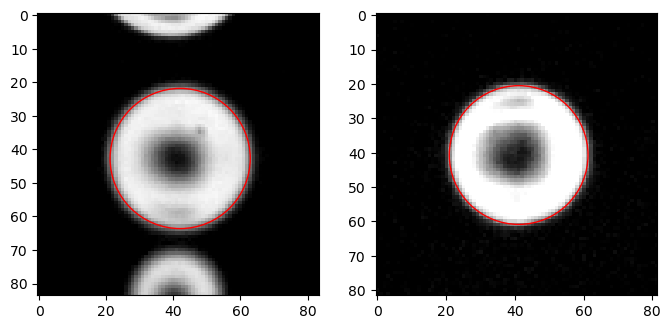

In [13]:
# plot 2d projection on each cam 
bb_id = 6
bb3d = bb3d_list[bb_id]
r3d = r3d_list_all[bb_id]
print(f'Bubble {bb_id} 3d radius: {r3d}')

fig, axs = plt.subplots(1, ncam, figsize=(8, 6))
for cam_id in range(ncam):
    bb2d = bb3d._bb2d_list[cam_id]

    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    f = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]
    r2d = r3d * f / np.sqrt(dist2 - r3d**2)
    
    ratio = 2
    row_min = int(np.floor(bb2d._pt_center[1] - ratio*r2d))
    row_max = int(np.ceil(bb2d._pt_center[1] + ratio*r2d))
    col_min = int(np.floor(bb2d._pt_center[0] - ratio*r2d))
    col_max = int(np.ceil(bb2d._pt_center[0] + ratio*r2d))
    img_size = min(row_max - row_min, col_max - col_min)

    img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
    img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))

    axs[cam_id].imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    draw_circle(axs[cam_id], np.array([bb2d._pt_center[0],bb2d._pt_center[1]]) - np.array([col_min, row_min]), r2d, color='red')
    
    print(f'Bubble {bb_id} projected 2d radius on cam {cam_id}: {r2d}')
    print(f'Bubble {bb_id} found 2d radius on cam {cam_id}: {bb2d._r_px}')

### Shake for bubbles

In [17]:
shake = lpt.stb.Shake(cam_list=cam_list, shake_width=0.02 * 30, tol_3d=3*sm_param.tor_3d, score_min=0.1, n_loop=4, n_thread=6)

# img2 = lpt.math.Image(img_list[1])
# for i in range(img2.getDimRow() * img2.getDimCol()):
#     img2[i] = max(0.0, img2[i] - 48000)

# img_list2 = []
# img_list2.append(lpt.math.Image(img_list[0]))
# img_list2.append(img2)

# add a little uncertainty to the bubble position
bb_id = 28
bb3d_list[bb_id]._pt_center[0] += .8 * bb3d_list[bb_id]._r3d
bb3d_list[bb_id]._pt_center[1] += .8 * bb3d_list[bb_id]._r3d
cam_useid = [0, 1]
bb3d_list[bb_id].projectObject2D(cam_useid, cam_list.cam_list)

bb3d_list_shake = shake.runShake(bb3d_list, img_list, bb_refimg, tri_only=False)

is_ghost = shake._is_ghost
print('Number of ghost bubbles:', np.sum(is_ghost))
print('Ghost ID:', np.where(is_ghost)[0])

bb17 = bb3d_list_shake[17]
#output the 2d position of bubble 17 on the second camera
bb2d = bb17._bb2d_list[1]   
print(f'Bubble 17 2d position on cam 2: {bb2d._pt_center[0]},{bb2d._pt_center[1]} radius: {bb2d._r_px}')

Shake::calBubbleScore Warning: all cameras have high intensity ratio


Number of ghost bubbles: 1
Ghost ID: [19]
Bubble 17 2d position on cam 2: 1090.0803428796933,587.195328252827 radius: 16.614173859413455


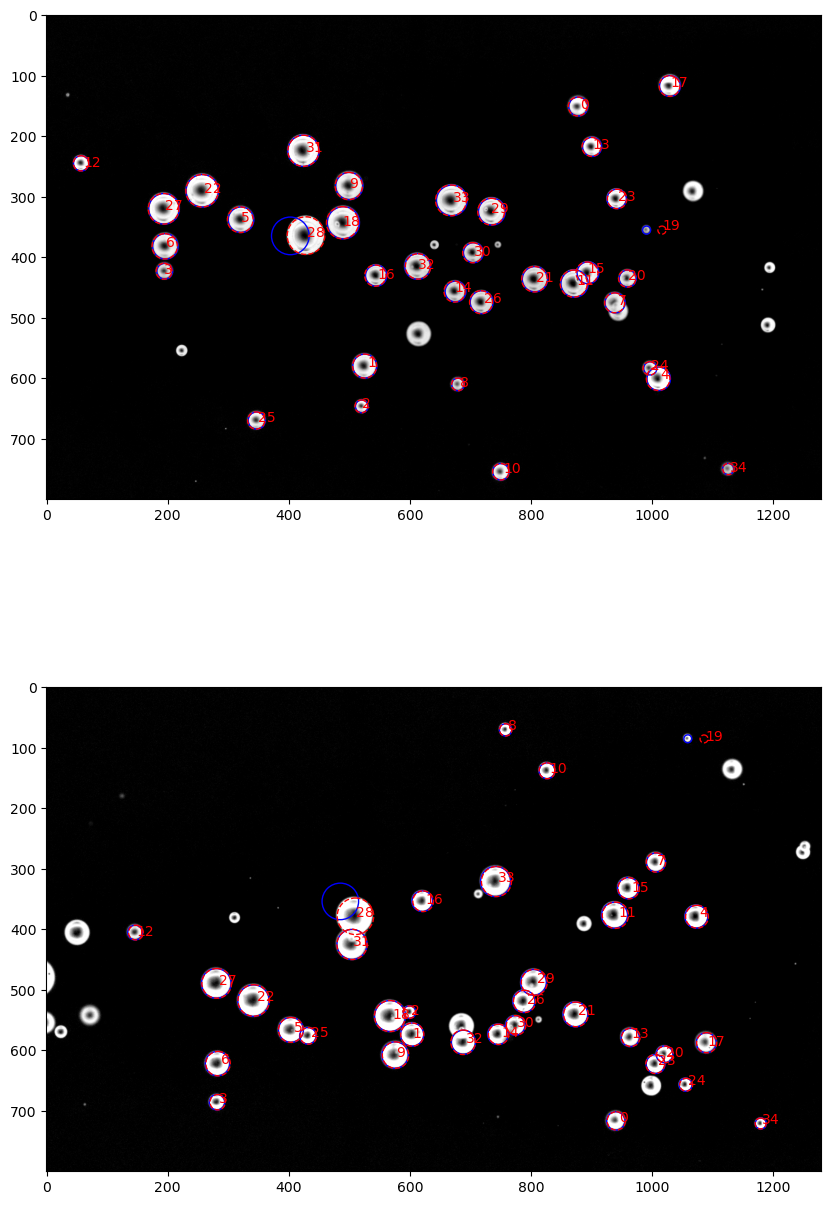

In [18]:
# project shaked 3d bubble on each cam
fig, axs = plt.subplots(ncam, 1, figsize=(10, 16))
# img_np_list2 = []
# img_np_list2.append(lpt.math.matrix_to_numpy(lpt.math.Image(img_list2[0])))
# img_np_list2.append(lpt.math.matrix_to_numpy(lpt.math.Image(img_list2[1])))
for cam_id in range(ncam):
    axs[cam_id].imshow(img_np_list[cam_id], cmap='gray', vmin=0, vmax=2**bit_depth-1)
    
    for i in range(len(bb3d_list)):
        bb3d = bb3d_list[i]
        bb2d = bb3d._bb2d_list[cam_id]
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='blue')
        
        # bb3d_copy = lpt.object.Bubble3D(bb3d)
        # bb3d_copy.projectObject2D(cam_list.useid_list, cam_list.cam_list)
        # draw_circle(axs[cam_id], bb3d_copy._bb2d_list[cam_id]._pt_center, bb3d_copy._bb2d_list[cam_id]._r_px, color='green',linestyle='--')

    for i in range(len(bb3d_list_shake)):
        bb3d = bb3d_list_shake[i]
        bb2d = bb3d._bb2d_list[cam_id]
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='red', linestyle='dashed')
        axs[cam_id].text(bb2d._pt_center[0] + 5 * np.random.random(), bb2d._pt_center[1] + 5 * np.random.random(), str(i), color='red', alpha=1.0)

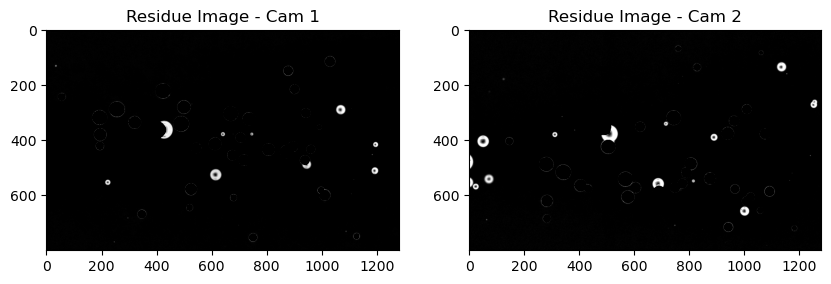

In [41]:
# debug shake
# calculate residue image
shake = lpt.stb.Shake(cam_list=cam_list, shake_width=0.02 * 20, tol_3d=3*sm_param.tor_3d, score_min=0.1, n_loop=4, n_thread=6)
residue_img_list = lpt.stb.calResImgBubble_debug(shake, bb3d_list, bb_refimg, img_list)

residue_img_list_np = []
for cam_id in range(ncam):
    residue_img_list_np.append(lpt.math.matrix_to_numpy(residue_img_list[cam_id]))
# plot residue image    
plt.figure(figsize=(10, 5))
for cam_id in range(ncam):  
    plt.subplot(1, ncam, cam_id + 1)
    plt.imshow(residue_img_list_np[cam_id], cmap='gray', vmin=0, vmax=2**bit_depth-1)
    plt.title(f'Residue Image - Cam {cam_id + 1}')

# img_aug_list = lpt.stb.ImgAugList()
# cor_map = lpt.math.Image()
# cam_mismatch = []

# img_aug_list = lpt.stb.calAugimgBubble_debug(img_list, bb3d)

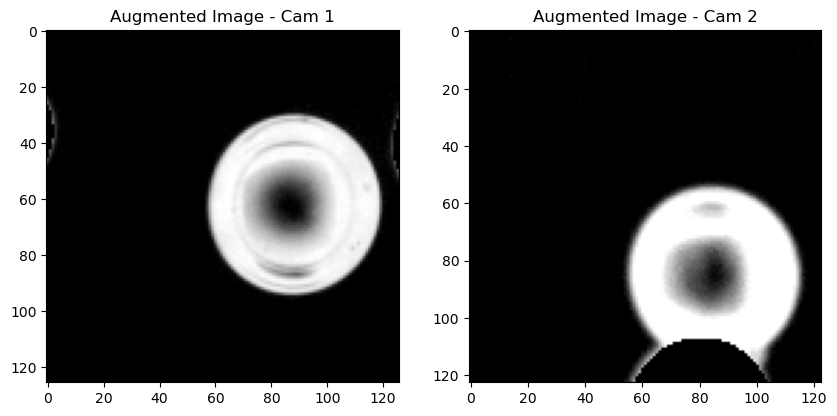

In [42]:
# calculate augmented image
corr_map_list = []
cam_mismatch = []

bb_17 = bb3d_list[18]
img_aug_list = lpt.stb.calAugimgBubble_debug(shake,bb_17, bb_refimg, img_list, corr_map_list, cam_mismatch)

# plot augmented image
plt.figure(figsize=(10, 5)) 
for cam_id in range(ncam):
    img_aug_np = lpt.math.matrix_to_numpy(img_aug_list.img_list[cam_id])
    plt.subplot(1, ncam, cam_id + 1)
    plt.imshow(img_aug_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    plt.title(f'Augmented Image - Cam {cam_id + 1}')


Maximum correlation point: (84, 85)
Corr range: -0.49571827 0.87845224


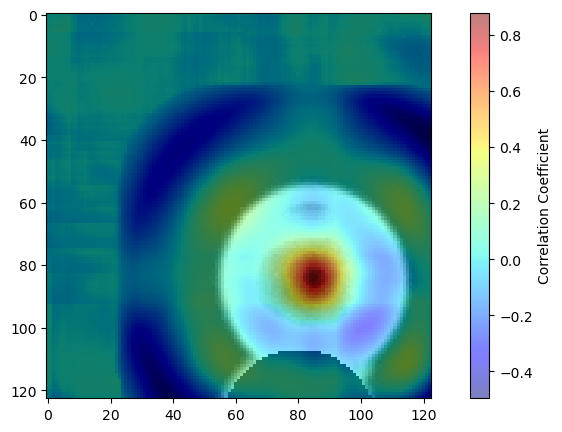

In [43]:
# calculate correlation map
cam_debug = 1

n_col = img_aug_list.img_list[1].getDimCol()
n_row = img_aug_list.img_list[1].getDimRow()

cor_map = np.zeros((n_row, n_col), dtype=np.float32)

# get the augmented image for the debug camera and subtract this image by 48000 for each pixel
img_aug_debug = lpt.math.Image(img_aug_list.img_list[cam_debug])
# img_aug_debug.write("img_aug_debug.csv")
# for i in range(img_aug_debug.getDimRow() * img_aug_debug.getDimCol()):
#     img_aug_debug[i] = max(0.0, img_aug_debug[i] - 48000)

for col in range(n_col):
    for row in range(n_row):
        center_x = col + img_aug_list.region_list[cam_debug].col_min
        center_y = row + img_aug_list.region_list[cam_debug].row_min
        cor_map[row, col] = lpt.stb.imgCrossCorr_debug(shake, img_aug_debug, img_aug_list.region_list[cam_debug], bb_refimg[cam_debug], cam_list.intensity_max[cam_debug],center_x, center_y, bb_17._bb2d_list[cam_debug]._r_px)

#plot correlation map overlaied with the original image
plt.figure(figsize=(10, 5)) 
plt.imshow(lpt.math.matrix_to_numpy(img_aug_list.img_list[cam_debug]), cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.imshow(cor_map, cmap='jet', alpha=0.5)  
plt.colorbar(label='Correlation Coefficient')
# find the maximum correlation point
max_row, max_col = np.unravel_index(np.argmax(cor_map), cor_map.shape)
# output the coordinates of the maximum correlation point
print(f'Maximum correlation point: ({max_row}, {max_col})')
print(f'Corr range:', np.min(cor_map), np.max(cor_map))


Text(0.5, 1.0, 'Bubble Image from Bubble Reference Image - Cam 2')

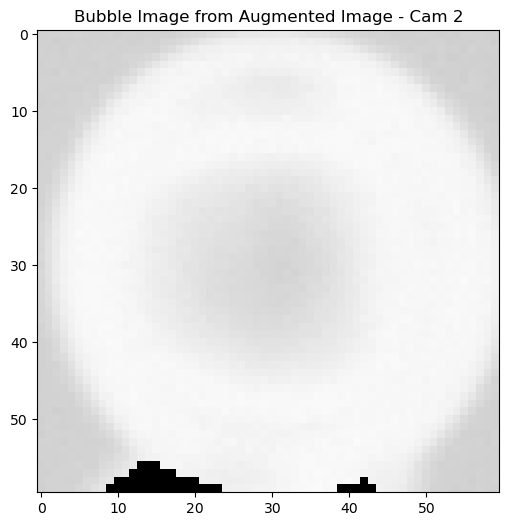

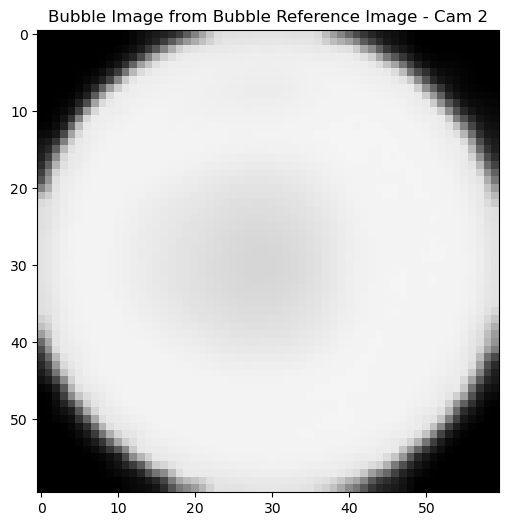

In [34]:
# get the bubble image from the augmented image at the 2D position of the bb_17 on the debug camera
bb2d = bb_17._bb2d_list[cam_debug]
row_min = int(np.floor(bb2d._pt_center[1] - img_aug_list.region_list[cam_debug].row_min - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] - img_aug_list.region_list[cam_debug].row_min + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - img_aug_list.region_list[cam_debug].col_min - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] - img_aug_list.region_list[cam_debug].col_min + bb2d._r_px))
img_size = min(row_max - row_min, col_max - col_min)
img_aug_debug_np = lpt.math.matrix_to_numpy(img_aug_debug)
img_aug_debug_np = img_aug_debug_np[row_min:row_min+img_size, col_min:col_min+img_size].copy()
# plot the bubble image from the augmented image
plt.figure(figsize=(8, 6))  
plt.imshow(img_aug_debug_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title(f'Bubble Image from Augmented Image - Cam {cam_debug + 1}')

# get the bubble image from the bubble reference image with radius of bb_17 on the debug camera
ref_img = lpt.math.Image(bb_refimg[cam_debug])
bb_resize = lpt.object.BubbleResize()
img_output = bb_resize.ResizeBubble(ref_img, int(np.round(bb2d._r_px * 2)), 2**bit_depth-1)
img_output_np = lpt.math.matrix_to_numpy(img_output)
# plot the bubble image from the bubble reference image
plt.figure(figsize=(8, 6))  
plt.imshow(img_output_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title(f'Bubble Image from Bubble Reference Image - Cam {cam_debug + 1}')